Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [1]:
from itertools import product, combinations
import numpy as np
import networkx as nx
from collections import defaultdict
import time
import heapq
from queue import PriorityQueue
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Tuple, Optional, Callable
import warnings
warnings.filterwarnings('ignore')

In [2]:
sizes = [10,20,50,100,200,500,1000]
density = [0.2,0.5,0.8,1.0]
noise_levels = [0.0, 0.1, 0.5, 0.8]
negative_values = [True, False]

In [3]:
def create_problem(
    size: int,
    *,
    # determines the sparsity, 
    # for every possible connection there is only a density% chance that a direct road exists
    density: float = 1.0,   
    negative_values: bool = False,
    noise_level: float = 0.0,
    seed: int = 42,
) -> np.ndarray:
    """Problem generator for Lab3"""
    rng = np.random.default_rng(seed)
    map = rng.random(size=(size, 2))
    problem = rng.random((size, size))
    if negative_values:
        problem = problem * 2 - 1
    problem *= noise_level
    for a, b in product(range(size), repeat=2):
        #check inside a loop over all pairs, directed graph.
        if rng.random() < density:
            # cost to travel between two nodes 
            problem[a, b] += np.sqrt(
                np.square(map[a, 0] - map[b, 0]) + np.square(map[a, 1] - map[b, 1])
            )
        else:
            problem[a, b] = np.inf
    np.fill_diagonal(problem, 0)
    return (problem * 1_000).round(), map

In [4]:
rng = np.random.default_rng(42)  # Same seed as create_problem
node_map = rng.random(size=(10, 2))  # Extract the positions
node_positions = {i: (node_map[i, 0], node_map[i, 1]) for i in range(10)}

problem = create_problem(10, density=0.15, noise_level=10, negative_values=False)
problem

(array([[    0.,    inf, 10573.,    inf,  8430.,    inf,    inf,   831.,
          1977.,    inf],
        [   inf,     0.,    inf,    inf,    inf,  2434.,    inf,    inf,
            inf,  6771.],
        [   inf,    inf,     0.,    inf,    inf,    inf,    inf,    inf,
            inf,  2208.],
        [   inf,    inf,  8563.,     0.,  7768.,    inf,    inf,    inf,
            inf,    inf],
        [ 7330.,    inf,    inf,  8367.,     0.,    inf,    inf,    inf,
            inf,    inf],
        [   inf,    inf,    inf,    inf,    inf,     0.,    inf,    inf,
            inf,    inf],
        [   inf,    inf,    inf,    inf,    inf,    inf,     0.,  5247.,
            inf,    inf],
        [   inf,    inf,  5287.,    inf,    inf,    inf,    inf,     0.,
            inf,    inf],
        [   inf,    inf,    inf, 10443.,  8363.,    inf,  5258.,    inf,
             0.,    inf],
        [   inf,    inf,    inf,    inf,    inf,    inf,  7850.,  7752.,
            inf,     0.]]),
 array([

In [5]:
class PathfindingAlgorithm:
    
    def __init__(self, name: str):
        self.name = name
        self.nodes_expanded = 0
        self.execution_time = 0
    
    def search(self, graph, start: int, goal: int) -> Tuple[Optional[List[int]], float]:
        """Returns (path, cost) or (None, inf) if no path exists"""
        raise NotImplementedError
    
    def reset_metrics(self):
        self.nodes_expanded = 0
        self.execution_time = 0

In [6]:
class DijkstraAlgorithm(PathfindingAlgorithm):
    """Dijkstra's algorithm - optimal for non-negative weights"""
    
    def __init__(self):
        super().__init__("Dijkstra")
    
    def search(self, graph, start: int, goal: int) -> Tuple[Optional[List[int]], float]:
        self.reset_metrics()
        start_time = time.perf_counter()
        
        # Priority queue: (cost, node)
        pq = [(0, start)]
        visited = set()
        cost_so_far = {start: 0}
        parent = {start: None}
        
        while pq:
            current_cost, current = heapq.heappop(pq)
            
            if current in visited:
                continue
            
            visited.add(current)
            self.nodes_expanded += 1
            
            if current == goal:
                path = self._reconstruct_path(parent, start, goal)
                self.execution_time = time.perf_counter() - start_time
                return path, current_cost
            
            for neighbor in graph[current]:
                edge_weight = graph[current][neighbor].get('weight', 1)
                new_cost = current_cost + edge_weight
                
                if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                    cost_so_far[neighbor] = new_cost
                    parent[neighbor] = current
                    heapq.heappush(pq, (new_cost, neighbor))
        
        self.execution_time = time.perf_counter() - start_time
        return None, float('inf')
    
    def _reconstruct_path(self, parent, start, goal):
        path = []
        current = goal
        while current is not None:
            path.append(current)
            current = parent[current]
        return path[::-1]

In [7]:
#Bellman-Ford to handle negative weights.

def bellman_ford_search(
    graph,
    start,
    goal,
    parent_state,
    state_cost,
):
    

    # Initialize
    nodes = list(graph.nodes())
    for node in nodes:
        state_cost[node] = float("inf")
        parent_state[node] = None

    state_cost[start] = 0

    # Relax edges iterating through all nodes |V|-1 times
    for _ in range(len(nodes) - 1):
        changed = False
        for u in nodes:
            if state_cost[u] == float("inf"):
                continue
            # explore neighbors
            for v in graph[u]:
                weight = graph[u][v].get("weight", 1)
                if state_cost[u] + weight < state_cost[v]:
                    state_cost[v] = state_cost[u] + weight
                    parent_state[v] = u
                    changed = True
    
        # Early stopping if no changes
        if not changed:
            break
    
    # Check for negative-weight cycles
    for u in nodes:
        if state_cost[u] != float("inf"):
            for v in graph[u]:
                weight = graph[u][v].get("weight", 1)
                if state_cost[u] + weight < state_cost[v]:
                    raise ValueError("Graph contains a negative-weight cycle")
                
    # Reconstruct path
    if state_cost[goal] == float("inf"):
        return None, float("inf")
    
    path = []
    s = goal
    while s is not None:
        path.append(s)
        s = parent_state[s]
    path.reverse()
    return path, state_cost[goal]

In [8]:
#Bellman-Ford algorithm - handles negative weights, detects negative cycles

class BellmanFordAlgorithm(PathfindingAlgorithm):
    
    def __init__(self):
        super().__init__("Bellman-Ford")
    
    def search(self, graph, start: int, goal: int) -> Tuple[Optional[List[int]], float]:
        self.reset_metrics()
        start_time = time.perf_counter()
        
        nodes = list(graph.nodes())
        distance = {node: float('inf') for node in nodes}
        parent = {node: None for node in nodes}
        distance[start] = 0
        
        # Relax edges |V|-1 times
        for iteration in range(len(nodes) - 1):
            updated = False
            for u in nodes:
                if distance[u] == float('inf'):
                    continue
                self.nodes_expanded += 1
                for v in graph[u]:
                    weight = graph[u][v].get('weight', 1)
                    if distance[u] + weight < distance[v]:
                        distance[v] = distance[u] + weight
                        parent[v] = u
                        updated = True
            
            if not updated:  # Early termination
                break
        
        # Check for negative cycles
        for u in nodes:
            if distance[u] != float('inf'):
                for v in graph[u]:
                    weight = graph[u][v].get('weight', 1)
                    if distance[u] + weight < distance[v]:
                        self.execution_time = time.perf_counter() - start_time
                        raise ValueError("Negative cycle detected")
        
        self.execution_time = time.perf_counter() - start_time
        
        if distance[goal] == float('inf'):
            return None, float('inf')
        
        path = self._reconstruct_path(parent, start, goal)
        return path, distance[goal]
    
    def _reconstruct_path(self, parent, start, goal):
        path = []
        current = goal
        while current is not None:
            path.append(current)
            current = parent[current]
        return path[::-1]

In [9]:
# A* algorithm with configurable heuristic

class AStarAlgorithm(PathfindingAlgorithm):
    
    def __init__(self, heuristic_func: Callable, name_suffix: str = ""):
        super().__init__(f"A*{name_suffix}")
        self.heuristic = heuristic_func
    
    def search(self, graph, start: int, goal: int) -> Tuple[Optional[List[int]], float]:
        self.reset_metrics()
        start_time = time.perf_counter()
        
        # Priority queue: (f_score, counter, node)
        counter = 0
        pq = [(self.heuristic(start, goal), counter, start)]
        visited = set()
        g_score = {start: 0}
        parent = {start: None}
        
        while pq:
            _, _, current = heapq.heappop(pq)
            
            if current in visited:
                continue
            
            visited.add(current)
            self.nodes_expanded += 1
            
            if current == goal:
                path = self._reconstruct_path(parent, start, goal)
                self.execution_time = time.perf_counter() - start_time
                return path, g_score[current]
            
            for neighbor in graph[current]:
                edge_weight = graph[current][neighbor].get('weight', 1)
                tentative_g = g_score[current] + edge_weight
                
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    g_score[neighbor] = tentative_g
                    parent[neighbor] = current
                    f_score = tentative_g + self.heuristic(neighbor, goal)
                    counter += 1
                    heapq.heappush(pq, (f_score, counter, neighbor))
        
        self.execution_time = time.perf_counter() - start_time
        return None, float('inf')
    
    def _reconstruct_path(self, parent, start, goal):
        path = []
        current = goal
        while current is not None:
            path.append(current)
            current = parent[current]
        return path[::-1]

In [10]:
# Johnson's algorithm: optimal for all-pairs shortest paths with negative weights

class JohnsonAlgorithm(PathfindingAlgorithm):
    
    def __init__(self):
        super().__init__("Johnson")
        self.reweighted = False
        self.h_values = None
    
    def search(self, graph, start: int, goal: int) -> Tuple[Optional[List[int]], float]:
        self.reset_metrics()
        start_time = time.perf_counter()
        
        # First time: compute potentials
        if not self.reweighted:
            self._compute_potentials(graph)
        
        # Use Dijkstra on reweighted graph
        pq = [(0, start)]
        visited = set()
        cost_so_far = {start: 0}
        parent = {start: None}
        
        while pq:
            current_cost, current = heapq.heappop(pq)
            
            if current in visited:
                continue
            
            visited.add(current)
            self.nodes_expanded += 1
            
            if current == goal:
                path = self._reconstruct_path(parent, start, goal)
                # Convert back to original weights
                original_cost = self._get_original_cost(path, graph)
                self.execution_time = time.perf_counter() - start_time
                return path, original_cost
            
            for neighbor in graph[current]:
                # Reweighted edge: w'(u,v) = w(u,v) + h(u) - h(v)
                original_weight = graph[current][neighbor].get('weight', 1)
                reweighted = original_weight + self.h_values[current] - self.h_values[neighbor]
                new_cost = current_cost + reweighted
                
                if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                    cost_so_far[neighbor] = new_cost
                    parent[neighbor] = current
                    heapq.heappush(pq, (new_cost, neighbor))
        
        self.execution_time = time.perf_counter() - start_time
        return None, float('inf')
    
    # Compute h values using Bellman-Ford from artificial source
    def _compute_potentials(self, graph):
        nodes = list(graph.nodes())
        
        # Add artificial source node
        distance = {node: float('inf') for node in nodes}
        artificial_source = -1
        distance[artificial_source] = 0
        
        # Relax edges from artificial source (0 weight to all nodes)
        for node in nodes:
            distance[node] = 0
        
        # Standard Bellman-Ford relaxation
        for _ in range(len(nodes)):
            for u in nodes:
                if distance[u] == float('inf'):
                    continue
                for v in graph[u]:
                    weight = graph[u][v].get('weight', 1)
                    if distance[u] + weight < distance[v]:
                        distance[v] = distance[u] + weight
        
        self.h_values = {node: distance[node] for node in nodes}
        self.reweighted = True
    
    # Calculate cost using original edge weights
    def _get_original_cost(self, path, graph):
        if not path or len(path) < 2:
            return 0
        
        cost = 0
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            cost += graph[u][v].get('weight', 1)
        return cost
    
    def _reconstruct_path(self, parent, start, goal):
        path = []
        current = goal
        while current is not None:
            path.append(current)
            current = parent[current]
        return path[::-1]

In [11]:
# Zero heuristic (A* should become Dijkstra)
def create_zero_heuristic():
    return lambda state, goal: 0

# Euclidean distance heuristic
def create_euclidean_heuristic(node_positions):
    def heuristic(state, goal):
        x1, y1 = node_positions[state]
        x2, y2 = node_positions[goal]
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2) * 1000
    return heuristic

# Manhattan distance heuristic
def create_manhattan_heuristic(node_positions):
    def heuristic(state, goal):
        x1, y1 = node_positions[state]
        x2, y2 = node_positions[goal]
        return (abs(x2 - x1) + abs(y2 - y1)) * 1000
    return heuristic

In [12]:
def select_algorithms(size: int, density: float, negative_values: bool, 
                     noise_level: float, node_positions: dict) -> List[PathfindingAlgorithm]:

    algorithms = []
    
    # Always include Dijkstra as baseline for non-negative weights
    if not negative_values:
        algorithms.append(DijkstraAlgorithm())
        
        # A* variants with different heuristics
        algorithms.append(AStarAlgorithm(create_euclidean_heuristic(node_positions), " (Euclidean)"))
        algorithms.append(AStarAlgorithm(create_manhattan_heuristic(node_positions), " (Manhattan)"))
    
    # Algorithms for negative weights
    if negative_values:
        algorithms.append(BellmanFordAlgorithm())
        algorithms.append(JohnsonAlgorithm())
        # A* with zero heuristic (becomes Dijkstra but handles negatives differently)
        algorithms.append(AStarAlgorithm(create_zero_heuristic(), " (Zero-h)"))
    
        
    return algorithms

In [13]:
class BenchmarkResults:
    
    def __init__(self):
        self.results = []
    
    def add_result(self, problem_config: dict, algorithm: str, 
                   path_found: bool, path_length: int, cost: float,
                   nodes_expanded: int, execution_time: float,
                   optimal: bool):
        self.results.append({
            'size': problem_config['size'],
            'density': problem_config['density'],
            'negative_values': problem_config['negative_values'],
            'noise_level': problem_config['noise_level'],
            'algorithm': algorithm,
            'path_found': path_found,
            'path_length': path_length,
            'cost': cost,
            'nodes_expanded': nodes_expanded,
            'execution_time_ms': execution_time * 1000,
            'optimal': optimal
        })
    
    def to_dataframe(self):
        return pd.DataFrame(self.results)
    
    def get_summary_statistics(self):
        df = self.to_dataframe()
        
        summary = df.groupby(['algorithm', 'size', 'negative_values']).agg({
            'execution_time_ms': ['mean', 'std', 'min', 'max'],
            'nodes_expanded': ['mean', 'std', 'min', 'max'],
            'path_found': 'sum',
            'optimal': 'sum'
        }).round(4)
        
        return summary

In [14]:
def run_comprehensive_benchmark(test_configurations: List[dict], 
                               sample_pairs: int = 10) -> BenchmarkResults:
    
    from networkx.exception import NetworkXUnbounded
    
    results = BenchmarkResults()
    total_configs = len(test_configurations)

    for config_idx, config in enumerate(test_configurations):

        print(f"\n{'='*80}")
        print(f"Configuration {config_idx + 1}/{total_configs}")
        print(f"Size: {config['size']}, Density: {config['density']}, "
              f"Negative: {config['negative_values']}, Noise: {config['noise_level']}")
        print(f"{'='*80}")
        
        # Generate problem
        problem, node_map = create_problem(**config)
        node_positions = {i: (node_map[i, 0], node_map[i, 1]) for i in range(config['size'])}
        
        # Create graph
        masked = np.ma.masked_array(problem, mask=np.isinf(problem))
        G = nx.from_numpy_array(masked, create_using=nx.DiGraph)
        
        # Select appropriate algorithms
        algorithms = select_algorithms(
            config['size'], config['density'], 
            config['negative_values'], config['noise_level'], 
            node_positions
        )
        
        print(f"Testing {len(algorithms)} algorithms: {[alg.name for alg in algorithms]}")
        
        # Generate random start-goal pairs
        rng = np.random.default_rng(config.get('seed', 42) + 1000)
        nodes = list(range(config['size']))
            
        tested_pairs = 0  
        attempts = 0      
        max_attempts = sample_pairs * 10
        
        while tested_pairs < sample_pairs and attempts < max_attempts: 
            attempts += 1
            start, goal = rng.choice(nodes, size=2, replace=False)

            try:
                # Use bellman_ford for negative weights, dijkstra for non-negative
                if config['negative_values']:
                    nx_path = nx.bellman_ford_path(G, start, goal, weight='weight')
                    nx_cost = nx.bellman_ford_path_length(G, start, goal, weight='weight')
                else:                         # <-- Check for the colon here
                    nx_path = nx.shortest_path(G, start, goal, weight='weight')
                    nx_cost = nx.path_weight(G, nx_path, weight='weight')       
            except (nx.NetworkXNoPath, nx.NetworkXUnbounded): 
                continue  
                    
            tested_pairs += 1
            
            # Test each algorithm
            for algo in algorithms:
                try:
                    path, cost = algo.search(G, start, goal)
                    
                    path_found = path is not None
                    path_length = len(path) if path else 0
                    optimal = abs(cost - nx_cost) < 1e-6 if path_found else False
                    
                    results.add_result(
                        problem_config=config,
                        algorithm=algo.name,
                        path_found=path_found,
                        path_length=path_length,
                        cost=cost,
                        nodes_expanded=algo.nodes_expanded,
                        execution_time=algo.execution_time,
                        optimal=optimal
                    )
                    
                except Exception as e:
                    print(f"  {algo.name} failed: {str(e)}")
                    results.add_result(
                        problem_config=config,
                        algorithm=algo.name,
                        path_found=False,
                        path_length=0,
                        cost=float('inf'),
                        nodes_expanded=0,
                        execution_time=0,
                        optimal=False
                    )
        
        print(f"Tested {tested_pairs} valid path pairs")
    
    return results

In [15]:
def create_comprehensive_visualizations(results: BenchmarkResults):
    df = results.to_dataframe()
    
    # Filter out failed attempts
    df_success = df[df['path_found'] == True].copy()
    
    fig = plt.figure(figsize=(18, 25)) 
    
    gs = fig.add_gridspec(5, 2, hspace=0.6, wspace=0.4) 
    
    # --- ROW 1 ---
    # 1. Execution Time by Algorithm and Size (gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 0])
    pivot_time = df_success.pivot_table(
        values='execution_time_ms', 
        index='size', 
        columns='algorithm', 
        aggfunc='mean'
    )
    pivot_time.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title('1. Avg Execution Time by Size', fontweight='bold', fontsize=15)
    ax1.set_xlabel('Problem Size (Nodes)', fontweight='bold')
    ax1.set_ylabel('Time (ms, Log Scale)', fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax1.set_yscale('log')
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Nodes Expanded by Algorithm (gs[0, 1])
    ax2 = fig.add_subplot(gs[0, 1])
    pivot_nodes = df_success.pivot_table(
        values='nodes_expanded', 
        index='size', 
        columns='algorithm', 
        aggfunc='mean'
    )
    pivot_nodes.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_title('2. Avg Nodes Expanded by Size', fontweight='bold', fontsize=15)
    ax2.set_xlabel('Problem Size (Nodes)', fontweight='bold')
    ax2.set_ylabel('Nodes Expanded (Log Scale)', fontweight='bold')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax2.set_yscale('log')
    ax2.grid(axis='y', alpha=0.3)

    # --- ROW 2 ---
    # 3. Success Rate (gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 0])
    success_rate = df.groupby('algorithm')['path_found'].mean() * 100
    success_rate.plot(kind='barh', ax=ax3, color='skyblue', edgecolor='black')
    ax3.set_title('3. Path Finding Success Rate', fontweight='bold', fontsize=15)
    ax3.set_xlabel('Success Rate (%)', fontweight='bold')
    ax3.set_xlim(0, 105)
    ax3.grid(axis='x', alpha=0.3)
    
    # 4. Optimality Rate (gs[1, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    optimality = df_success.groupby('algorithm')['optimal'].mean() * 100
    optimality.plot(kind='barh', ax=ax4, color='lightgreen', edgecolor='black')
    ax4.set_title('4. Optimality Rate', fontweight='bold', fontsize=15)
    ax4.set_xlabel('Optimality (%)', fontweight='bold')
    ax4.set_xlim(0, 105)
    ax4.grid(axis='x', alpha=0.3)
    
    
    # Final cleanup to ensure proper spacing
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    plt.suptitle('Pathfinding Algorithms Comparison', 
                 fontsize=24, fontweight='bold', y=0.98)
    
    return fig

In [16]:
def create_detailed_comparison_table(results: BenchmarkResults):
    df = results.to_dataframe()
    df_success = df[df['path_found'] == True]
    
    # Group by algorithm and aggregate metrics
    summary = df_success.groupby('algorithm').agg({
        'execution_time_ms': ['mean', 'std', 'min', 'max'],
        'nodes_expanded': ['mean', 'std', 'min', 'max'],
        'path_found': 'count',
        'optimal': 'sum'
    }).round(4)
    
    # Calculate optimality percentage
    summary['optimality_pct'] = (summary[('optimal', 'sum')] / summary[('path_found', 'count')] * 100).round(2)
    
    return summary

COMPREHENSIVE PATHFINDING ALGORITHMS COMPARISON 

Total configurations to test: 224
Starting benchmark...


Configuration 1/224
Size: 10, Density: 0.2, Negative: True, Noise: 0.0
Testing 3 algorithms: ['Bellman-Ford', 'Johnson', 'A* (Zero-h)']
Tested 10 valid path pairs

Configuration 2/224
Size: 10, Density: 0.2, Negative: False, Noise: 0.0
Testing 3 algorithms: ['Dijkstra', 'A* (Euclidean)', 'A* (Manhattan)']
Tested 10 valid path pairs

Configuration 3/224
Size: 10, Density: 0.2, Negative: True, Noise: 0.1
Testing 3 algorithms: ['Bellman-Ford', 'Johnson', 'A* (Zero-h)']
Tested 10 valid path pairs

Configuration 4/224
Size: 10, Density: 0.2, Negative: False, Noise: 0.1
Testing 3 algorithms: ['Dijkstra', 'A* (Euclidean)', 'A* (Manhattan)']
Tested 10 valid path pairs

Configuration 5/224
Size: 10, Density: 0.2, Negative: True, Noise: 0.5
Testing 3 algorithms: ['Bellman-Ford', 'Johnson', 'A* (Zero-h)']
Tested 10 valid path pairs

Configuration 6/224
Size: 10, Density: 0.2, Negative: Fals

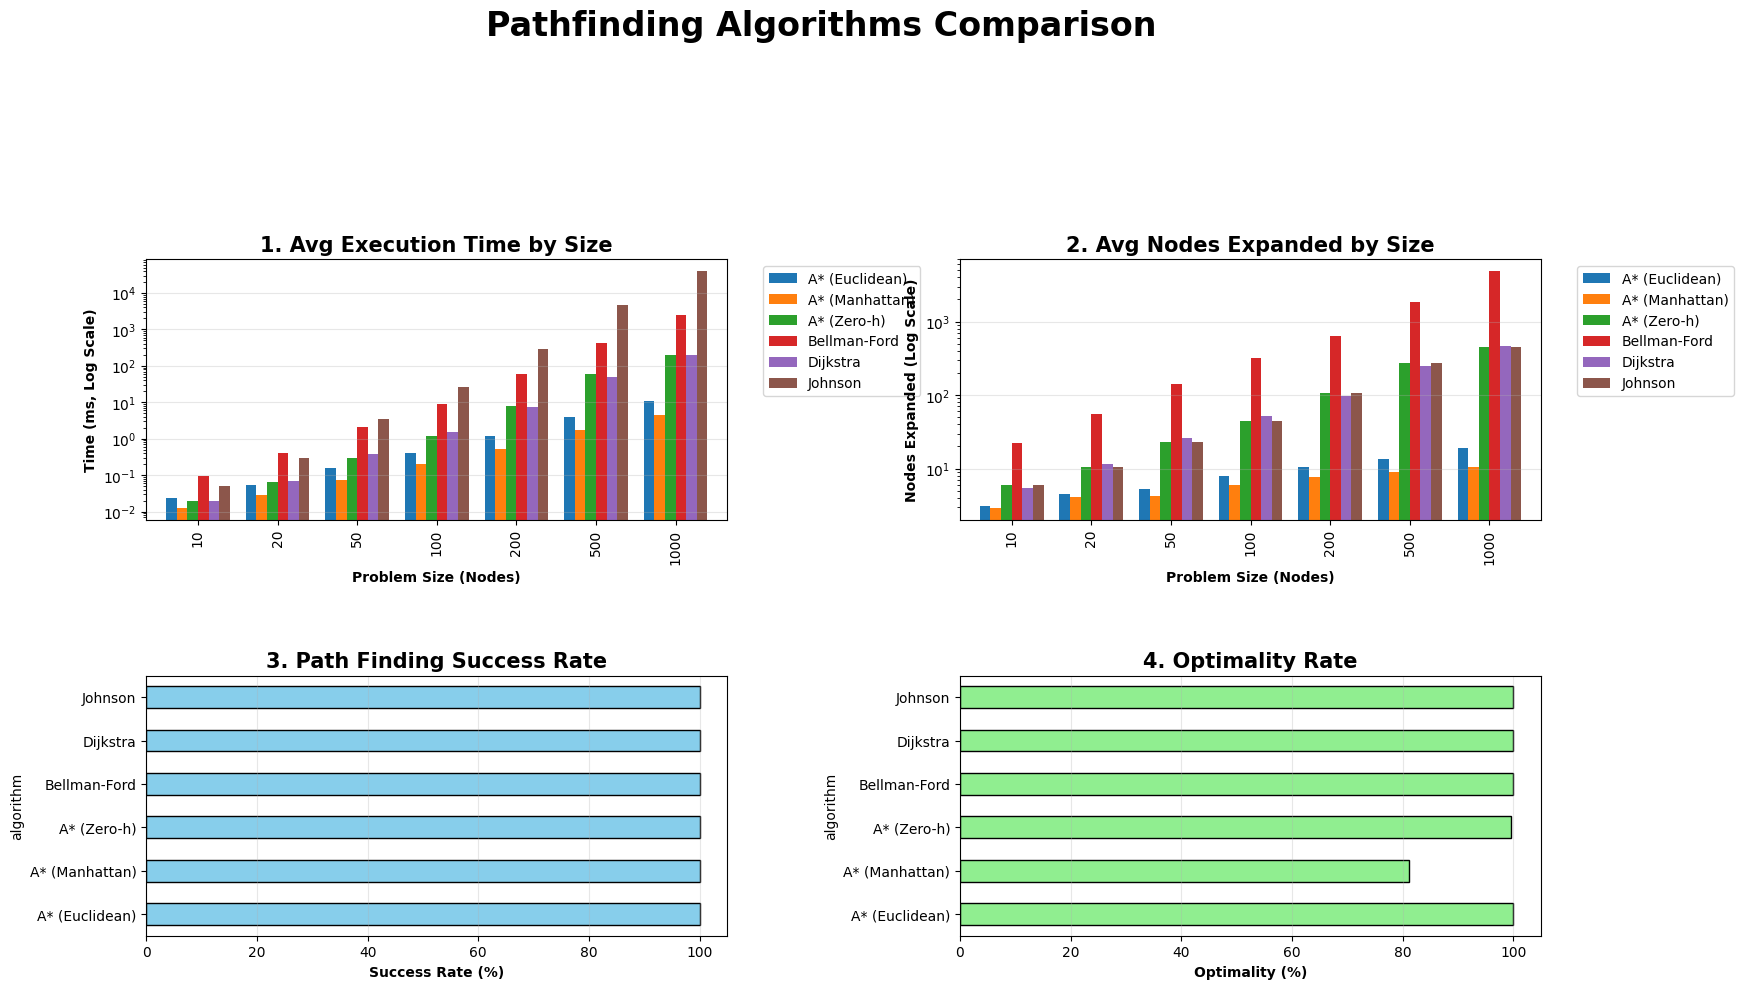

In [17]:
def main():
    """Main execution function"""
    
    print("="*80)
    print("COMPREHENSIVE PATHFINDING ALGORITHMS COMPARISON ")
    print("="*80)
    
    # Define test parameters
    sizes = [10, 20, 50, 100, 200, 500, 1000]
    density = [0.2, 0.5, 0.8, 1.0]
    noise_levels = [0.0, 0.1, 0.5, 0.8]
    negative_values = [True, False]
    
    # Generate all configurations using the Cartesian product
    all_configs = []
    seed_counter = 42 # Starting seed for unique problem generation
    
    
    for size, dens, noise, neg_val in product(sizes, density, noise_levels, negative_values):
        all_configs.append({
            'size': size,
            'density': dens,
            'negative_values': neg_val,
            'noise_level': noise,
            'seed': seed_counter
        })
        seed_counter += 1
    
    # Note: This generates 7 x 4 x 4 x 2 = 224 unique configurations.
    print(f"\nTotal configurations to test: {len(all_configs)}")
    print("Starting benchmark...\n")
    
    # Run comprehensive benchmark
    # The benchmark will now process 224 configurations, with 10 pairs each.
    results = run_comprehensive_benchmark(all_configs, sample_pairs=10)
    
    print("\n" + "="*80)
    print("BENCHMARK COMPLETED")
    print("="*80)
    
    # Generate visualizations
    file_name = 'pathfinding_comparison_charts.png'
    print(f"\nGenerating visualizations and saving to '{file_name}'...")
    fig = create_comprehensive_visualizations(results)
    fig.savefig(file_name, bbox_inches='tight', dpi=300) 
    
    # Generate detailed table
    print("\n" + "="*80)
    print("DETAILED COMPARISON TABLE")
    print("="*80)
    summary_table = create_detailed_comparison_table(results)
    print(summary_table)
    
    # Export results
    df = results.to_dataframe()
    df.to_csv('pathfinding_benchmark_results.csv', index=False)
    print("\nResults exported to 'pathfinding_benchmark_results.csv'")
    
    # Algorithm recommendations (Analysis logic remains the same)
    print("\n" + "="*80)
    print("ALGORITHM RECOMMENDATIONS")
    print("="*80)
    
    df_success = df[df['path_found'] == True]
    
    print("\n1. FOR NON-NEGATIVE WEIGHTS:")
    non_neg = df_success[df_success['negative_values'] == False]
    if len(non_neg) > 0:
        best_time = non_neg.groupby('algorithm')['execution_time_ms'].mean().idxmin()
        best_nodes = non_neg.groupby('algorithm')['nodes_expanded'].mean().idxmin()
        print(f"   - Fastest: {best_time}")
        print(f"   - Most Efficient (fewest nodes): {best_nodes}")
        print("   - Recommended: Dijkstra for dense graphs, A* (Euclidean) for sparse graphs")
    
    print("\n2. FOR NEGATIVE WEIGHTS:")
    neg = df_success[df_success['negative_values'] == True]
    if len(neg) > 0:
        best_time = neg.groupby('algorithm')['execution_time_ms'].mean().idxmin()
        best_nodes = neg.groupby('algorithm')['nodes_expanded'].mean().idxmin()
        print(f"   - Fastest: {best_time}")
        print(f"   - Most Efficient (fewest nodes): {best_nodes}")
        print("   - Recommended: Johnson's algorithm for multiple queries, Bellman-Ford for single queries")
    
    print("\n3. SCALABILITY:")
    for size in sorted(df_success['size'].unique()):
        size_data = df_success[df_success['size'] == size]
        fastest = size_data.groupby('algorithm')['execution_time_ms'].mean().idxmin()
        print(f"   - Size {size}: {fastest}")
    
    print("\n4. BY GRAPH DENSITY:")
    for density in sorted(df_success['density'].unique()):
        density_data = df_success[df_success['density'] == density]
        fastest = density_data.groupby('algorithm')['execution_time_ms'].mean().idxmin()
        print(f"   - Density {density}: {fastest}")
    
    
    # Performance insights
    avg_time_by_algo = df_success.groupby('algorithm')['execution_time_ms'].mean().sort_values()
    print(f"\n- Fastest algorithm on average: {avg_time_by_algo.index[0]} ({avg_time_by_algo.values[0]:.4f} ms)")
    print(f"- Slowest algorithm on average: {avg_time_by_algo.index[-1]} ({avg_time_by_algo.values[-1]:.4f} ms)")
    
    efficiency_by_algo = df_success.groupby('algorithm')['nodes_expanded'].mean().sort_values()
    print(f"\n- Most efficient (fewest nodes): {efficiency_by_algo.index[0]} ({efficiency_by_algo.values[0]:.1f} nodes)")
    print(f"- Least efficient: {efficiency_by_algo.index[-1]} ({efficiency_by_algo.values[-1]:.1f} nodes)")
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
    
    return results

# %%
# Execute the main function
if __name__ == "__main__":
    results = main()